In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from matplotlib.gridspec import GridSpec
warnings.filterwarnings('ignore')

In [2]:
bq_path = '../BrightQuery_NationalFunding_Extracts_20240118/'
bq_files = os.listdir(bq_path)
ukeys = ['bq_id', 'bq_organization_id']
# 'bq_legal_entity_id'
unique_key = 'bq_id'
col_location_dic = {'vendor_ags': ('bq_company_variables_most_recent.csv', 'bq_revenue_mr'), 'vendor_business_start_year': ('bq_company_firmographics.csv', 'bq_year_founded'), 'vendor_SIC4': ('bq_company_firmographics.csv', 'bq_sic_code'), 
              'vendor_employee_count': ('bq_company_variables_most_recent.csv','bq_current_employees_plan_mr'), 'vendor_company_type' : ('bq_company_firmographics.csv', 'bq_company_lfo'), 
              'vendor_SIC2' : ('bq_company_firmographics.csv', 'bq_sic_sector_code'), 'vendor_report_date': ('bq_company_variables_most_recent.csv','bq_report_date_mr')}
bq_nf_matched_file = '../bq_national_funding_matched.csv'
vendor_test_data_dnb = '../../vender_test_data_dnb.csv'
vendor_test_data_internal = '../../vendor_test_data_internal_ags.csv'
#  'vendor_credit_score': ('bq_company_firmographics.csv', 'bq_score')
ags_cutoffs = [0, 100000, 500000, float('inf')]
emp_cutoffs = [0, 2, 5, float('inf')]
alt_ags_cutoffs = [0, 230000, 270000, float('inf')]
# tiers for self reported data
tier_dic = {'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3}
tier_cutoffs = [0, 250000, 1000000, float('inf')]

# over/under 250k bin
cutoffs_250 = [0,250000,float('inf')]
vendor = 'BrightQuery'
# days between vendor report date and NF mail date 
delta_mail_date = 120

# dictionary to rename company type in DnB comptype_hq column
comp_type_dic = {'G' : 'Proprietorship', 'H': 'Partnership', 'I' : 'Corporation', 'J' : 'Non Profit', 'O': 'Other'}
# Align NF General Non Profit status with more specific type from BQ
vendor_np_dic = {'Non-Profit Corporation' : 'Non Profit', 'Non-Profit Organization' : 'Non Profit', 'Limited Liability Company' : 'Other'}
comparate_base_dic = {'nf': 'NF', 'dnb': 'D&B', 'vendor': 'BrightQuery'}

In [3]:
def data_checker(path, ukeys, bq_nf_matched_file):
    """
    Function to evaluate missing data and identify unique keys used in vendor data files
    and a dictionary spefifying the unique key present in the file

    Args:
        path: (str) : path to files to be read / combined
        ukeys (list) : unique keys used to identify business in the files
        bq_nf_matched_file (.csv) : File of companies matching bq_id and NF unique_id 

    Returns:
        dataframe: combined dataframe containing missing value info and key uniqueness,
        dictionary specifying the unique key present in the file
    """
    files = os.listdir(path)
    bq_nf_mdf = pd.read_csv(bq_nf_matched_file, dtype={'bq_id': 'string'})
    print('csv read')
    datasources = []
    col_info = []
    unique_join_key = dict()
    for file in files:
        df= pd.read_csv(path + file, dtype={'bq_id': 'string'})
        statf = pd.DataFrame({'cols': df.columns, 'n_unique': df.apply(pd.Series.nunique), 'missing_values': df.isnull().sum()})
        file_name = file
        statf.insert(loc=0, column='file_name', value=file_name)
        statf.insert(loc=1, column = 'row_count', value=df.shape[0])
        statf.insert(loc=2, column='col_count', value = df.shape[1])
        statf[['row_count', 'col_count']] = statf[['row_count', 'col_count']].apply(pd.to_numeric)
        statf = statf.assign(missing_rate = lambda x: (x['missing_values'] / x['row_count'] * 100).round(2))
        print('missing rate calculated')
        statf['company_match_rate'] = statf.apply(lambda x: (bq_nf_mdf['bq_id'].isin(df['bq_id']).sum() / len(bq_nf_mdf)) * 100 if 'bq_id' in df.columns else 'n/a', axis=1)
        print('match_rate')
        for ukey in ukeys:
            if ukey in df.columns:
                statf[ukey + '_unique_rate'] = df[ukey].nunique()/len(df) * 100
        statf = statf.sort_values('missing_values', ascending=False)
        #clean up columns of repeated information
        filef = statf.copy()
        statf.loc[statf['file_name'].duplicated(), 'file_name'] = ''
        statf.loc[statf['row_count'].duplicated(), 'row_count'] = ''
        statf.loc[statf['col_count'].duplicated(), 'col_count'] = ''
        statf.loc[statf['company_match_rate'].duplicated(), 'company_match_rate'] = ''
        statf = statf.fillna('')

        col_info.append(filef)
        datasources.append(statf)
        unique_join_key[file] = [ukey for ukey in ukeys if ukey in list(df.columns)]
    table_stats = pd.concat(datasources)
    table_stats = table_stats.reset_index(drop=True)
    col_stats = pd.concat(col_info)
    col_stats = col_stats.reset_index(drop=True)
    col_stats.to_csv('output/data_checker.csv')

    return col_stats, unique_join_key, table_stats

In [4]:
def file_matcher(path, matching_file, unique_key, col_location_dic):
    """  
    Matches desired columns from vendor files with vendor / nf match sheet

    Args
        path (str): path to the desired files to match
        matching_file (str): nf file to be matched
        unique_key (str): unique key from vendor used for matching
        col_location_dic (dict): dictionary specifying desired columns from each file
    
    Returns
        dataframe matching desired columns by unique key
    """

    table_columns = defaultdict(list)
    #dictionary pairing file name with desired columns
    for key, value in col_location_dic.items(): 
        table_columns[value[0]].append(value[1])  
    columns_ = {key: value for (key, value) in table_columns.items() if value != []}
    files = columns_.keys()
    print(files)
    matched_df = pd.read_csv(matching_file, dtype={'bq_id': 'string'})
    for file in files:
        df = pd.read_csv(path + file, dtype={'bq_id':'string' })
        cols = list(table_columns[file])
        cols.append(unique_key)
        df = df[cols]
        if not df.empty:
            matched_df = pd.merge(matched_df, df, how='left', on=[unique_key])
    matched_df['bq_sic_code'] = matched_df['bq_sic_code'].astype(str)
    matched_df['bq_sic_code'] = matched_df['bq_sic_code'].apply(lambda x: x.split(';'))
    matched_df['bq_sic_code'] = matched_df['bq_sic_code'].apply(lambda x: list(map(str.strip, x)))
    matched_df['bq_sic_sector_code'] = matched_df['bq_sic_sector_code'].astype(str)
    matched_df['bq_sic_sector_code'] = matched_df['bq_sic_sector_code'].apply(lambda x: x.split(';'))
    
    matched_df['bq_sic_sector_code'] = matched_df['bq_sic_sector_code'].apply(lambda x: list(map(str.strip, x)))
    return matched_df
    

In [5]:
def rename_columns(col_location_dic, matched_data):
    """
    Function to rename vendor columns

    Args:
        col_locations (dict): dictionary with column locations and corresponding column names
        df (dataframe): dataframe with columns to be renamed 

    Returns:
        dataframe with generically named vendor columns
    """
    col_rename = {}
    for key, value in col_location_dic.items():
        col_rename[value[1]] = key
    matched_data = matched_data.rename(columns=col_rename)
    return matched_data

In [6]:
def dnb_x_nf_test_data(vendor_test_data_dnb, vendor_test_data_internal):
    """
    Function to align NF test data with D&B test data

    Args
        vendor_test_data_dnb (.csv) : D&B test data spreadsheet
        vendor_test_data_internal (.csv): internal test data spreadsheet

    Returns
        test_data (dataframe) : aligned NF and D&B data with desired columns 
    """

    dnb_td = pd.read_csv(vendor_test_data_dnb, dtype={'sic4' : 'string', 'sic2': 'string'})
    internal_td = pd.read_csv(vendor_test_data_internal, dtype={'sic_code': 'string'})

    # highestcredit is not the correct column
    dnb_td = dnb_td[['unique_id', 'run_date', 'bus_strt_yr', 'gc_sales', 'gc_employees', 'sic4', 'sic2', 'highestcredit', 'comptype_hq']]
    dnb_td = dnb_td.rename(columns={'run_date': 'dnb_run_date', 'bus_strt_yr': 'dnb_business_start_year', 'gc_sales': 'dnb_ags',
                                    'gc_employees': 'dnb_employee_count', 'sic4': 'dnb_sic4', 'sic2': 'dnb_sic2', 'highestcredit': 'dnb_credit_score', 'comptype_hq': 'dnb_company_type'})
    #dnb_td['dnb_sic4'] = dnb_td['dnb_sic4'].astype(str).apply(lambda x: x.replace('.0', ''))
    #dnb_td['dnb_sic2'] = dnb_td['dnb_sic2'].astype(str).apply(lambda x: x.replace('.0',''))
    dnb_td['dnb_sic4'] = dnb_td.apply(lambda x: x['dnb_sic4'] if  pd.isnull(x['dnb_sic4']) or len(x['dnb_sic4']) == 4 else '0' + x['dnb_sic4'],axis=1)
    dnb_td['dnb_run_date'] = pd.to_datetime(dnb_td['dnb_run_date'])
    internal_td = internal_td[['unique_id', 'run_date', 'mail_date', 'company', 'credit_review_ags', 'business_start_date', 'sic_code', 'flg_type', 'is_self_reporting_ags_gr25k', 'self_reporting_distribution_tier']]
    internal_td = internal_td.rename(columns={'run_date': 'nf_run_date', 'mail_date': 'nf_mail_date','credit_review_ags': 'nf_ags', 'business_start_date': 'nf_business_start_year', 'sic_code': 'nf_sic4', 'flg_type': 'nf_flg_type', 'is_self_reporting_ags_gr25k': 'sr_ags_ou_250_bin'})
    internal_td['nf_business_start_year'] = pd.DatetimeIndex(internal_td['nf_business_start_year']).year
    #internal_td['nf_sic4'] = internal_td['nf_sic4'].astype(str)
    internal_td['nf_run_date'] = pd.to_datetime(internal_td['nf_run_date'])
    internal_td['nf_mail_date'] = pd.to_datetime(internal_td['nf_mail_date'])
    
    #test_data = dnb_td.merge(internal_td, on='unique_id' )
    test_data = pd.merge(internal_td, dnb_td, how='left', on='unique_id')
    return test_data

In [7]:
def nf_dnb_vendor_comps(vendor_df, dnb_nf_test_data, ags_cutoffs, emp_cutoffs, cutoffs_250, comp_type_dic, vendor_np_dic, tier_dic, tier_cutoffs, vendor):
    """
    Function to align and compare NationalFunding, D&B, and vendor test data

    Args:
        vendor_df (dataframe) : dataframe of vendor test data
        dnb_nf_test_data (dataframe) : dataframe of combined NF and D&B data
        sales_cutoffs (list) : ranges for bins for average gross sales
        emp_cutoffs (list) : ranges for bins for average number of employees
        cutoffs_250 (list) : alternative ranges for bins for average gross sales
        comp_type_dic (dict) : dictionary for translating company type code from DnB
        vendor__np_dic (dict) : dictionary for translating company type from vendor

    Returns
        combined_df (dataframe) : dataframe with all comparison points between nf, dnb, and vendor
        nf_vendor_comp (dataframe) : dataframe comparing NF collected data with vendor data
    """
    # for Matched Columns 3, 2 = missing data

    labels = [0,1,2]
    labelshort = [0,1]
    combined_df = dnb_nf_test_data.merge(vendor_df, on='unique_id')
    combined_df['nf_ags_bin'] = pd.to_numeric(pd.cut(x=combined_df['nf_ags'], bins = ags_cutoffs, labels=labels))
    combined_df['dnb_ags_bin'] = pd.to_numeric(pd.cut(x=combined_df['dnb_ags'], bins=ags_cutoffs, labels=labels))
    combined_df['vendor_ags_bin'] = pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=ags_cutoffs, labels=labels))
    combined_df['nf_dnb_ags_bin_diff'] = combined_df['dnb_ags_bin'] - combined_df['nf_ags_bin']
    combined_df['nf_dnb_ags_per_diff'] = (combined_df['dnb_ags'] - combined_df['nf_ags']) / combined_df['nf_ags'] * 100 
    combined_df['nf_vendor_ags_bin_diff'] = (combined_df['vendor_ags_bin'] - combined_df['nf_ags_bin']).astype('string')
    combined_df['nf_vendor_ags_per_diff'] =  (combined_df['vendor_ags'] - combined_df['nf_ags']) / combined_df['nf_ags'] * 100
    combined_df['dnb_vendor_ags_bin_diff'] = (combined_df['vendor_ags_bin'] - combined_df['dnb_ags_bin']).astype('string')
    combined_df['dnb_vendor_ags_per_diff'] =  (combined_df['vendor_ags'] - combined_df['dnb_ags'])/combined_df['dnb_ags'] * 100
    combined_df['dnb_vendor_ags_bin_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['dnb_ags_bin']) else 2 if np.isnan(x['vendor_ags_bin']) else 1 if x['dnb_vendor_ags_bin_diff'] == '0' else 0, axis=1)
    combined_df['nf_vendor_ags_bin_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['nf_ags_bin']) else 2 if np.isnan(x['vendor_ags_bin']) else 1 if x['nf_vendor_ags_bin_diff'] == '0' else 0, axis=1)
    combined_df['nf_dnb_ags_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_ags_bin']) or np.isnan(x['nf_ags_bin']) else 1 if x['nf_dnb_ags_bin_diff'] == '0' else 0, axis=1)


    combined_df['dnb_vendor_ags_bin_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_ags_bin']) else 'DnB' if np.isnan(x['dnb_ags_bin']) else x['dnb_vendor_ags_bin_diff'], axis=1)
    combined_df['nf_vendor_ags_bin_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_ags_bin']) else 'NF' if np.isnan(x['nf_ags_bin']) else x['nf_vendor_ags_bin_diff'], axis=1)
  
    #bins matched / not matched
    # combined_df['nf_ags_250_bin'] = pd.to_numeric(pd.cut(x=combined_df['nf_ags'], bins=alt_ags_cutoffs, labels=labels))
    # combined_df['dnb_ags_250_bin'] = pd.to_numeric(pd.cut(x=combined_df['dnb_ags'], bins=alt_ags_cutoffs, labels=labels))
    # combined_df['vendor_ags_250_bin'] = pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=alt_ags_cutoffs,labels=labels))
    # combined_df['dnb_vendor_ags_250_bin_diff'] = combined_df['vendor_ags_250_bin'] - combined_df['dnb_ags_250_bin']
    # combined_df['nf_vendor_ags_250_bin_diff'] = combined_df['vendor_ags_250_bin'] - combined_df['nf_ags_250_bin']
    
    combined_df['nf_ags_ou_250_bin'] =  pd.to_numeric(pd.cut(x=combined_df['nf_ags'], bins=cutoffs_250, labels=labelshort))
    combined_df['dnb_ags_ou_250_bin'] =  pd.to_numeric(pd.cut(x=combined_df['dnb_ags'], bins=cutoffs_250, labels=labelshort))
    combined_df['vendor_ags_ou_250_bin'] =  pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=cutoffs_250,labels=labelshort))
    combined_df['dnb_vendor_ags_ou_250_bin_diff'] = (combined_df['vendor_ags_ou_250_bin'] - combined_df['dnb_ags_ou_250_bin']).astype('string')
    combined_df['nf_vendor_ags_ou_250_bin_diff'] = (combined_df['vendor_ags_ou_250_bin'] - combined_df['nf_ags_ou_250_bin']).astype('string')
    combined_df['dnb_vendor_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['dnb_ags_ou_250_bin']) else 2 if np.isnan(x['vendor_ags_ou_250_bin']) else 1 if x['dnb_vendor_ags_ou_250_bin_diff'] == '0.0' else 0, axis=1)
    combined_df['nf_vendor_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['nf_ags_ou_250_bin']) else 2 if np.isnan(x['vendor_ags_ou_250_bin']) else 1 if x['nf_vendor_ags_ou_250_bin_diff'] == '0.0' else 0, axis=1)
    combined_df['nf_dnb_ags_ou_250_bin_diff'] = combined_df['dnb_ags_ou_250_bin'] - combined_df['nf_ags_ou_250_bin']
    combined_df['nf_dnb_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_ags_ou_250_bin']) or np.isnan(x['nf_ags_ou_250_bin']) else 1 if x['nf_dnb_ags_ou_250_bin_diff'] == 0 else 0, axis=1)

    combined_df['dnb_vendor_ags_ou_250_bin_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_ags_bin']) else 'DnB' if np.isnan(x['dnb_ags_bin']) else x['dnb_vendor_ags_ou_250_bin_diff'], axis=1)
    combined_df['nf_vendor_ags_ou_250_bin_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_ags_bin']) else 'NF' if np.isnan(x['nf_ags_bin']) else x['nf_vendor_ags_ou_250_bin_diff'], axis=1)

    # make percent diff?
    combined_df['nf_dnb_start_year_diff'] = combined_df['dnb_business_start_year'] - combined_df['nf_business_start_year']
    combined_df['nf_vendor_start_year_diff'] = combined_df['vendor_business_start_year'] - combined_df['nf_business_start_year']
    combined_df['dnb_vendor_start_year_diff'] = combined_df['vendor_business_start_year'] -  combined_df['dnb_business_start_year']

    combined_df['dnb_vendor_sy_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['dnb_business_start_year']) else 2 if np.isnan(x['vendor_business_start_year']) else 1 if x['dnb_vendor_start_year_diff'] == 0 else 0, axis=1)
    combined_df['nf_vendor_sy_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['nf_business_start_year']) else 2 if np.isnan(x['vendor_business_start_year']) else 1 if x['nf_vendor_start_year_diff'] == 0 else 0, axis=1)
    combined_df['nf_dnb_sy_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['dnb_business_start_year']) or np.isnan(x['nf_business_start_year']) else 1 if x['nf_dnb_start_year_diff'] == 0 else 0, axis=1)

    combined_df = combined_df.replace({'dnb_company_type': comp_type_dic, 'vendor_company_type': vendor_np_dic})

    combined_df['dnb_vendor_company_type_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['dnb_company_type']) else 2 if pd.isnull(x['vendor_company_type']) else 1 if x['dnb_company_type'] == x['vendor_company_type'] else 0, axis=1)
    
    # Creating 2 digit NF SIC codes from 4 digit SIC2
    combined_df['nf_sic2'] = combined_df['nf_sic4'].str.slice(0,2)


    
    #BQ does not have any missing SIC4

    combined_df['nf_vendor_sic4_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['nf_sic4']) else 1 if x['nf_sic4'] in x['vendor_SIC4'] else 0, axis=1) 
    combined_df['nf_vendor_sic2_match'] = combined_df.apply(lambda x:  2 if pd.isnull(x['nf_sic2']) else 1 if x['nf_sic2'] in x['vendor_SIC2'] else 0, axis=1)
    combined_df['dnb_vendor_sic4_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['dnb_sic4']) else  1 if x['dnb_sic4'] in x['vendor_SIC4'] else 0, axis=1)
    combined_df['dnb_vendor_sic2_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['dnb_sic2']) else  1 if x['dnb_sic2'] in x['vendor_SIC2'] else 0, axis=1)

    combined_df['nf_dnb_sic4_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['nf_sic4']) or pd.isnull(x['dnb_sic4']) else  1 if x['nf_sic4'] == x['dnb_sic4'] else 0, axis=1)
    combined_df['nf_dnb_sic2_match'] = combined_df.apply(lambda x: 2 if pd.isnull(x['nf_sic2']) or pd.isnull(x['dnb_sic2']) else  1 if x['nf_sic2'] == x['dnb_sic2'] else 0, axis=1)

    # time delta between vendor report time and NF mail date
    combined_df['vendor_report_date'] = pd.to_datetime(combined_df['vendor_report_date'])
    combined_df['days_from_mail_date'] = combined_df['vendor_report_date'] - combined_df['nf_mail_date']

    #combined_df['dnb_self_above_250_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['sr_ags_ou_250_bin']) or np.isnan(x['dnb_ags_ou_250_bin']) else 1 if x['sr_ags_ou_250_bin'] == x['dnb_ags_ou_250_bin'] else 0, axis=1)
    #combined_df['nf_self_above_250_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['sr_ags_ou_250_bin']) or np.isnan(x['nf_ags_ou_250_bin']) else 1 if x['sr_ags_ou_250_bin'] == x['nf_ags_ou_250_bin'] else 0, axis=1)
    #combined_df['dnb_self_ou_250_bin_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['sr_ags_ou_250_bin']) or np.isnan(x['dnb_ags_ou_250_bin']) else 1 if x['sr_ags_ou_250_bin'] == x['dnb_ags_ou_250_bin'] else 0, axis=1)
    combined_df['sr_vendor_ags_ou_250_bin_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['sr_ags_ou_250_bin']) else 2 if np.isnan(x['vendor_ags_ou_250_bin']) else 1 if x['sr_ags_ou_250_bin'] == x['vendor_ags_ou_250_bin'] else 0, axis=1)
    
    labels = [1,2,3]
    combined_df['sr_ags_tier'] = combined_df['self_reporting_distribution_tier'].map(tier_dic)
    combined_df['vendor_ags_tier'] = pd.to_numeric(pd.cut(x=combined_df['vendor_ags'], bins=tier_cutoffs, labels=labels))
    combined_df['sr_vendor_tier_match'] = combined_df.apply(lambda x: 2 if np.isnan(x['sr_ags_tier']) or np.isnan(x['vendor_ags_tier']) else 1 if x['sr_ags_tier'] == x['vendor_ags_tier'] else 0, axis=1)
    combined_df['sr_vendor_tier_diff'] = (combined_df['vendor_ags_tier'] - combined_df['sr_ags_tier']).astype('string')
    combined_df['sr_vendor_ou_250_bin_diff'] = (combined_df['vendor_ags_ou_250_bin'] - combined_df['sr_ags_ou_250_bin']).astype('string')

    combined_df['sr_vendor_tier_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_ags_tier']) else 'SR' if np.isnan(x['sr_ags_tier']) else x['sr_vendor_tier_diff'], axis=1)
    combined_df['sr_vendor_ou_250_bin_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_ags_bin']) else 'SR' if np.isnan(x['sr_ags_ou_250_bin']) else x['sr_vendor_ou_250_bin_diff'], axis=1)


    nf_vendor_comp_df = combined_df.dropna(subset = ['nf_ags'])
    nf_vendor_comp_df = nf_vendor_comp_df.reset_index(drop=True)
    labels = [1,2,3]
    combined_df['dnb_emp_bin'] = pd.to_numeric(pd.cut(x=combined_df['dnb_employee_count'], bins=emp_cutoffs, labels=labels))
    combined_df['vendor_emp_bin'] = pd.to_numeric(pd.cut(x=combined_df['vendor_employee_count'], bins=emp_cutoffs, labels=labels))
    combined_df['dnb_vendor_emp_bin_diff'] = (combined_df['vendor_emp_bin'] - combined_df['dnb_emp_bin']).astype('string')
    combined_df['dnb_vendor_emp_per_diff'] = (combined_df['vendor_employee_count'] - combined_df['dnb_employee_count']) / combined_df['dnb_employee_count'] * 100
    combined_df['dnb_vendor_emp_bin_match'] = combined_df.apply(lambda x: 3 if np.isnan(x['dnb_emp_bin']) else 2 if np.isnan(x['vendor_emp_bin']) else 1 if x['dnb_vendor_emp_bin_diff'] == '0' else 0, axis=1)
 
    combined_df['dnb_vendor_emp_bin_diff'] = combined_df.apply(lambda x: vendor if np.isnan(x['vendor_emp_bin']) else 'DnB' if np.isnan(x['dnb_emp_bin']) else x['dnb_vendor_emp_bin_diff'], axis=1)

    combined_df.to_csv('output/nf_dnb_vendor_comp.csv')
    nf_vendor_comp_df.to_csv('output/nf_vendor_comp.csv')

    dnb_compdf = combined_df
    nf_compdf = nf_vendor_comp_df

    return dnb_compdf, nf_compdf

In [8]:
col_stats, unique_join_key, table_stats = data_checker(bq_path, ukeys, bq_nf_matched_file)
matched_data = file_matcher(bq_path, bq_nf_matched_file, unique_key, col_location_dic)
matched_data = rename_columns(col_location_dic, matched_data)
dnb_nf_test_data = dnb_x_nf_test_data(vendor_test_data_dnb, vendor_test_data_internal)
df, nf_compdf = nf_dnb_vendor_comps(matched_data, dnb_nf_test_data, ags_cutoffs, emp_cutoffs, cutoffs_250, comp_type_dic, vendor_np_dic, tier_dic, tier_cutoffs, 'BrightQuery')

csv read
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
missing rate calculated
match_rate
dict_keys(['bq_company_variables_most_recent.csv', 'bq_company_firmographics.csv'])


In [9]:
# table for information for each file about shape, company match rate, id unique rate
def table_info(table_stats):
    table_stats = table_stats[['file_name', 'row_count', 'col_count', 'company_match_rate', 'bq_id_unique_rate', 'bq_organization_id_unique_rate']]
    file_mask = (table_stats['file_name'] != '')
    display(table_stats[file_mask].reset_index(drop=True))

In [10]:
# table for each files columns with most missing data
def top_10_by_file(col_stats):
    col_stats = col_stats[['file_name','cols','missing_rate']]
    files = col_stats['file_name'].unique()
    for file in files:
        file_mask = (col_stats['file_name'] == file)
        #col_stats.style.set_caption(file)
        display(col_stats[file_mask].drop(columns=['file_name']).head(10).style.set_caption(file).format({'missing_rate' : '{:.2f}'}).hide())

In [11]:
def fill_rates_tab(df, num_sent):
    features = ['ags', 'employee_count', 'business_start_year', 'SIC4', 'SIC2', 'company_type']
    matched_records = []
    sent_records = []
    for feature in features:
        matched_records.append((1 - (df['vendor_' + feature].isna().sum() / len(df))) * 100)
        sent_records.append(((df['vendor_' + feature].notna().sum() / num_sent)) * 100)
    return pd.DataFrame({'features': features,'matched_records': matched_records, 'sent_records': sent_records})

In [12]:
def funnel_stage_tab(df, vendor_test_data_internal_path):
    sent_df = pd.read_csv(vendor_test_data_internal_path)
    sent_flagdf = sent_df.groupby(['flg_type'])['flg_type'].count().to_frame(name='sent_flg_count').reset_index()
    match_flagdf = df.groupby(['nf_flg_type'])['nf_flg_type'].count().to_frame(name='matched_flag_count').reset_index()
    flags_matcheddf = pd.merge(sent_flagdf, match_flagdf, how='left', left_on='flg_type', right_on='nf_flg_type')
    flags_matcheddf['per_matched'] = flags_matcheddf['matched_flag_count'] / flags_matcheddf['sent_flg_count'] * 100
    return flags_matcheddf

In [13]:
def ags_stats_table(df, ulim, llim):
    # % over 250k
    sample_dfs = {'all_pop' : df,
                   'sr_pop': df.dropna(subset='sr_ags_ou_250_bin'),
                    'cr_pop': df.dropna(subset=['nf_ags']),
                     'rec_pop': df.dropna(subset='nf_ags')[(df['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (df['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))] }
    sources = ['vendor', 'dnb', 'nf', 'sr']
    over_250k_per = []
    table_dic = {'Stage': ['Marketing', 'Responding', 'Credit Review', 'Credit Review with Time Consideration']}
    ns = []
    for pop, frame in sample_dfs.items():
        ns.append(len(frame))
    table_dic['N'] = ns    
    for s in sources[:-1]:
        median_col = []
        for pop, frame in sample_dfs.items():
            median_col.append(frame[s + '_ags'].median())
        table_dic[s + '_median'] = median_col
    for s in sources:
        per_gr_250k = []
        for pop, frame in sample_dfs.items():
            per_gr_250k.append(len(frame[frame[s + '_ags_ou_250_bin'] == 1]) / len(frame) * 100)        
        table_dic[s + '_per_gr_250k'] = per_gr_250k
    for s in sources[1:]:
        match_250k = []
        for pop, frame in sample_dfs.items():
            match_250k.append(len(frame[frame[s + '_vendor_ags_ou_250_bin_match'] == 1]) / len(frame) * 100)
        table_dic[s + '_vendor_match_250k'] = match_250k
    for s in sources[1:-1]:
        mean_diff = []
        for pop, frame in sample_dfs.items():
            mean_diff.append(frame[(frame[s + '_vendor_ags_per_diff'] <= ulim) & (frame[s + '_vendor_ags_per_diff'] >= llim)][s + '_vendor_ags_per_diff'].mean())
        table_dic[s + '_vendor_mean_per_diff'] = mean_diff
    return pd.DataFrame(table_dic)

In [14]:
def ags_charts(df, ags_cutoffs, cutoffs_250, comparate, base, comparate_base_dic, delta_mail_date = None):
    # comparate / base valid inputs: dnb, nf, vendor
    #filter if nf data only
    comp = comparate
    if base == 'nf':
        df = df.dropna(subset=['nf_ags'])
        df = df.reset_index(drop=True)
    else:
        df = df
    #filter if recent
    if delta_mail_date == None:
        df = df
    else:
        dmask = (df['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (df['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))
        df = df[dmask]

    color7 = ['red', 'red', 'green', 'red', 'red', 'black', 'black']
    color3 = ['red', 'green', 'red', 'black', 'black']
    colorm = ['black', 'blue', 'blue', 'blue']
    colorm3 = ['black', 'blue', 'blue']
    x_labels_bin = ['missing', '<= $100k', '$100k - $500k', '> $500k']
    x_labels_bin_250 = ['missing','<= $250k', '> $250k']
    x_loc_bin = np.arange(len(x_labels_bin))
    x_loc_bin_250 = np.arange(len(x_labels_bin_250))
    x_labels_m = [vendor, base]
    x_loc_m = np.arange(len(x_labels_m))
    #narrow histogram from outliers
    lower_outbound = (df[base + '_' + comparate + '_ags_per_diff'] >=-500)
    upper_outbound = (df[base + '_' + comparate + '_ags_per_diff'] <= 500)
    out_mask = lower_outbound & upper_outbound
    # df for histogram
    dflim = df[out_mask]

    fig = plt.figure(figsize=(16,13),layout='constrained')
    gs = GridSpec(4, 2, figure=fig)
    fig.suptitle('{} vs {} AGS Data'.format(comparate_base_dic[base], comparate_base_dic[comparate]), fontsize='xx-large')
    mf = df[df['dnb_vendor_ags_ou_250_bin_match'] > 1]
    df[comp + '_ags_bin'] = df[comp + '_ags_bin'].fillna(-1)
    df[comp + '_ags_ou_250_bin'] = df[comp + '_ags_ou_250_bin'] .fillna(-1)

    ax1 = fig.add_subplot(gs[0,0])
    round(df[comp + '_ags_bin'].value_counts().sort_index()/len(df[comp + '_ags_bin'])*100,2).plot(ax=ax1, kind='bar', color=colorm)
    ax1.set_title('{} < {} < {} < {} Bin Distribution'.format(*ags_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc_bin, labels=x_labels_bin, rotation='horizontal')
    ax1.set_ylabel('%')
    t1 = 'n = {}'.format(len(df[comp + '_ags_bin']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    # adjust share y based on chart with tallest bar?
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    round(df[base + '_' + comp + '_ags_bin_diff'].value_counts().sort_index()/len(df[base + '_' + comp + '_ags_bin_diff'])*100, 2).plot(ax=ax2, kind='bar', color=color7)
    ax2.set_title('{} < {} < {} < {} Bin Difference'.format(*ags_cutoffs))
    ax2.bar_label(ax2.containers[0])
    t2 = 'n = {}'.format(len(df[base + '_' + comp + '_ags_bin_diff']))
    ax2.text(.85,.95,t2, transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    ax3 = fig.add_subplot(gs[1,0])
    round(df[comp + '_ags_ou_250_bin'].value_counts().sort_index()/len(df[comp + '_ags_ou_250_bin'])*100,2).plot(ax=ax3, kind='bar', color=colorm3)
    ax3.set_title('{} < {} < {} Bin Distribution'.format(*cutoffs_250))
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc_bin_250, labels=x_labels_bin_250, rotation='horizontal')
    ax3.set_ylabel('%')
    t3 = 'n = {}'.format(len(df[comp + '_ags_ou_250_bin']))
    ax3.text(.85,.95,t3, transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    round(df[base + '_' + comp + '_ags_ou_250_bin_diff'].value_counts().sort_index()/len(df[base + '_' + comp + '_ags_ou_250_bin_diff'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.set_title('{} < {} < {} Bin Difference'.format(*cutoffs_250))
    ax4.bar_label(ax4.containers[0])
    t4 = 'n = {}'.format(len(df[base + '_' + comp + '_ags_ou_250_bin_diff']))
    ax4.text(.85,.95,t4, transform=ax4.transAxes)
    ax4.set_ylim(0,100)

    ax5 = fig.add_subplot(gs[2:, :])
    ax5.set_title('% Differnce in AGS')
    values, bins, bars = ax5.hist(dflim[base + '_' + comp + '_ags_per_diff'], bins=50)
    ax5.bar_label(bars, size=9)
    ax5.set_ylabel('Count')
    t5 = 'n = {}\n{} values > 500%\n0 values < -100%\n\nExcluding Those Outliers:'.format(len(df[base + '_' + comp + '_ags_per_diff']),(len(df[~upper_outbound]))- df[comp + '_ags'].isnull().sum())
    ax5.axvline(x=0, color='white',ls='-',lw=1)
    ax5.axvline(x=dflim[base + '_' + comp + '_ags_per_diff'].median(),color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(dflim[base + '_' + comp + '_ags_per_diff'].median(),2)))
    ax5.axvline(x=dflim[base + '_' + comp + '_ags_per_diff'].mean(), color='m', ls='dotted', lw=2, label='Mean = {}%'.format(round(dflim[base + '_' + comp + '_ags_per_diff'].mean(), 2)))
    ax5.legend(loc='upper right', title=t5)

    plt.show()


In [15]:
def sr_ags_tier_charts(df, tier_cutoffs, cutoffs_250, comparate, comparate_base_dic):
    comp = comparate
    df = df.dropna(subset = 'sr_ags_ou_250_bin')
    df = df.reset_index(drop=True)
    color7 = ['red', 'red', 'green', 'red', 'red', 'black', 'black']
    color3 = ['red', 'green', 'red', 'black', 'black']
    colorm = ['black', 'blue', 'blue', 'blue']
    colorm3 = ['black', 'blue', 'blue']
    x_labels_bin = ['missing', '<= $250k', '$250k - $1m', '> 1m']
    x_labels_bin_250 = ['missing','<= $250k', '> $250k']
    x_loc_bin = np.arange(len(x_labels_bin))
    x_loc_bin_250 = np.arange(len(x_labels_bin_250))
    # x_labels_m = [vendor, base]
    # x_loc_m = np.arange(len(x_labels_m))

    fig = plt.figure(figsize=(12,12),layout='constrained')
    gs = GridSpec(4, 2, figure=fig)
    fig.suptitle('Self Report vs {} AGS Tiers Data'.format(comparate_base_dic[comp]), fontsize='xx-large')
    df[comp + '_ags_tier'] = df[comp + '_ags_tier'].fillna(-1)
    df[comp + '_ags_ou_250_bin'] = df[comp + '_ags_ou_250_bin'] .fillna(-1)

    ax1 = fig.add_subplot(gs[0,0])
    round(df[comp + '_ags_tier'].value_counts().sort_index()/len(df[comp + '_ags_tier'])*100,2).plot(ax=ax1, kind='bar', color=colorm)
    ax1.set_title('{} < {} < {} < {} Bin Distribution'.format(*tier_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc_bin, labels=x_labels_bin, rotation='horizontal')
    ax1.set_ylabel('%')
    t1 = 'n = {}'.format(len(df[comp + '_ags_tier']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    # adjust share y based on chart with tallest bar?
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    round(df['sr_' + comp + '_tier_diff'].value_counts().sort_index()/len(df['sr_' + comp + '_tier_diff'])*100, 2).plot(ax=ax2, kind='bar', color=color7)
    ax2.set_title('{} < {} < {} < {} Bin Difference'.format(*tier_cutoffs))
    ax2.bar_label(ax2.containers[0])
    t2 = 'n = {}'.format(len(df['sr_' + comp + '_tier_diff']))
    ax2.text(.85,.95,t2, transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    ax3 = fig.add_subplot(gs[1,0])
    round(df[comp + '_ags_ou_250_bin'].value_counts().sort_index()/len(df[comp + '_ags_ou_250_bin'])*100,2).plot(ax=ax3, kind='bar', color=colorm3)
    ax3.set_title('{} < {} < {} Bin Distribution'.format(*cutoffs_250))
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc_bin_250, labels=x_labels_bin_250, rotation='horizontal')
    ax3.set_ylabel('%')
    t3 = 'n = {}'.format(len(df['sr_' + comp + '_ags_ou_250_bin_match']))
    ax3.text(.85,.95,t3, transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1, 1], sharey=ax3)
    round(df['sr_' + comp + '_ou_250_bin_diff'].value_counts().sort_index()/len(df['sr_' + comp + '_ou_250_bin_diff'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.set_title('{} < {} < {} Bin Difference'.format(*cutoffs_250))
    ax4.bar_label(ax4.containers[0])
    t4 = 'n = {}'.format(len(df['sr_' + comp + '_ou_250_bin_diff']))
    ax4.text(.85,.95,t4, transform=ax4.transAxes)
    ax4.set_ylim(0,100)

    plt.show()

In [16]:
def bsy_charts(df, comparate, base, comparate_base_dic, delta_mail_date = None):
    comp = comparate
    if base == 'nf':
        df = df.dropna(subset=['nf_ags'])
        df = df.reset_index(drop=True)
    else:
        df = df
    #filter if recent
    if delta_mail_date == None:
        df = df
    else:
        dmask = (df['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (df['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))
        df = df[dmask]

    color = ['red' , 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(20,12), layout='constrained')
    gs = GridSpec(6,3, figure=fig)
    fig.suptitle('{} vs {} Business Start Year Comparison'.format(comparate_base_dic[base], comparate_base_dic[comparate]), fontsize='xx-large')

    # mask for outliers on hist
    ulim = 25
    llim = -25
    upper_outbound = (df[base + '_' + comp + '_start_year_diff'] < ulim)
    lower_outbound = (df[base + '_' + comp + '_start_year_diff'] > llim)
    outmask = lower_outbound & upper_outbound
    # df for histogram
    dflim = df[outmask]

    # dnb_vendor_sy_match
    ax1 = fig.add_subplot(gs[0:2,2:])
    round(df[base + '_' + comp + '_sy_match'].value_counts().sort_index()/len(df[base + '_' + comp + '_sy_match'])*100,2).plot(ax=ax1, kind='bar',color=color)
    ax1.set_title('Business Start Year Match')
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(df[base + '_' + comp + '_sy_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[3:,1:])
    ax2.set_title('Business Start Year Difference')
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=1)
    values, bins, bars = ax2.hist(dflim[base + '_' + comp + '_start_year_diff'], bins=bins)
    ax2.bar_label(bars, size=8)
    ax2.axvline(x=0, color='white',ls='--',lw=1)
    ax2.axvline(x=dflim[base + '_' + comp + '_start_year_diff'].median(), color='red', ls='dotted', lw=2, label='Median = {} years'.format(round(dflim[base + '_' + comp + '_start_year_diff'].median(),2)))
    ax2.axvline(x=dflim[base + '_' + comp + '_start_year_diff'].mean(), color='m', ls='dotted', lw=2, label='Mean = {} years'.format(round(dflim[base + '_' + comp + '_start_year_diff'].mean(),2)))
    #outliers without missing values
    df_nona = df.dropna(subset=[comp + '_business_start_year'])
    t5 = 'n = {}\n{} values < -25 years\n{} values > 25 years\n\nExcluding Those Outliers:'.format(len(df[base + '_' + comp + '_start_year_diff']), len(df_nona[~lower_outbound]), len(df_nona[~upper_outbound]))
    ax2.legend(loc='upper right', title=t5)
    
    plt.show()
    

In [17]:
def sic_charts(df, comparate, base, comparate_base_dic, delta_mail_date = None):
    comp = comparate
    if base == 'nf':
        df = df.dropna(subset=['nf_ags'])
        df = df.reset_index(drop=True)
    else:
        df = df
    #filter if recent
    if delta_mail_date == None:
        df = df
    else:
        dmask = (df['days_from_mail_date'] >= pd.Timedelta(-delta_mail_date, 'D')) & (df['days_from_mail_date'] <= pd.Timedelta(delta_mail_date, 'D'))
        df = df[dmask]


    color3 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))


    fig = plt.figure(figsize=(12,8), layout='constrained')
    gs = GridSpec(2,2, figure=fig)
    fig.suptitle('{} vs {} SIC Code Comparison'.format(comparate_base_dic[base], comparate_base_dic[comp]), fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('SIC4 Match Rate')
    round(df[base + '_' + comp + '_sic4_match'].value_counts().sort_index()/len(df[base + '_' + comp + '_sic4_match'])*100, 2).plot(ax=ax1, kind='bar', color=color3)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(df[base + '_' + comp + '_sic4_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[1,0])
    ax2.set_title('SIC2 Match Rate')
    round(df[base + '_' + comp + '_sic2_match'].value_counts().sort_index()/len(df[base + '_' + comp + '_sic2_match'])*100, 2).plot(ax=ax2, kind='bar', color=color3)
    ax2.bar_label(ax2.containers[0])
    ax2.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t2 = 'n = {}'.format(len(df[base + '_' + comp + '_sic2_match']))
    ax2.text(.85,.95,t2,transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    mask = (df[base + '_sic2'] != '99') | (df[base + '_sic2'].isnull())
    df_no99 = df[mask]
    ax3 = fig.add_subplot(gs[0,1])
    ax3.set_title('SIC4 Match Rate excluding 99')
    round(df_no99[base + '_' + comp + '_sic4_match'].value_counts().sort_index()/len(df_no99[base + '_' + comp + '_sic4_match'])*100, 2).plot(ax=ax3, kind='bar', color=color3)
    ax3.bar_label(ax3.containers[0])
    ax3.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t3 = 'n = {}'.format(len(df_no99[base + '_' + comp + '_sic4_match']))
    ax3.text(.85,.95,t3,transform=ax3.transAxes)
    ax3.set_ylim(0,100)

    ax4 = fig.add_subplot(gs[1,1])
    ax4.set_title('SIC2 Match Rate excluding 99')
    round(df_no99[base + '_' + comp + '_sic2_match'].value_counts().sort_index()/len(df_no99[base + '_' + comp + '_sic2_match'])*100, 2).plot(ax=ax4, kind='bar', color=color3)
    ax4.bar_label(ax4.containers[0])
    ax4.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t4 = 'n = {}'.format(len(df_no99[base + '_' + comp + '_sic2_match']))
    ax4.text(.85,.95,t4,transform=ax4.transAxes)
    ax4.set_ylim(0,100)

    plt.show()

In [18]:
def emp_charts(df, emp_cutoffs, comparate, base, comparate_base_dic):
    comp = comparate

    color7 = ['red', 'red', 'green', 'red', 'red', 'black', 'black']
    color3 = ['red', 'green', 'red', 'black', 'black']
    colorm = ['black', 'blue', 'blue', 'blue']
    colorm3 = ['black', 'blue', 'blue']
    x_labels_bin = ['missing', '<= 2', '2 - 5', '> 5']
    x_labels_bin_250 = ['missing','<= $250k', '> $250k']
    x_loc_bin = np.arange(len(x_labels_bin))
    x_loc_bin_250 = np.arange(len(x_labels_bin_250))
    # x_labels_m = [vendor, base]
    # x_loc_m = np.arange(len(x_labels_m))

    #filter outliers at start?
    lower_outbound = (df[base + '_' + comp + '_emp_per_diff'] >=-100)
    upper_outbound = (df[base + '_' + comp + '_emp_per_diff'] <= 100)
    out_mask = lower_outbound & upper_outbound
    # df for histogram filtering Outliers
    dflim = df[out_mask]

    fig = plt.figure(figsize=(12,9), layout='constrained')
    gs = GridSpec(2, 2, figure=fig)
    fig.suptitle('{} vs {} Employee Differential'.format(comparate_base_dic[base], comparate_base_dic[comp]), fontsize='xx-large')

    df['vendor_emp_bin'] = df['vendor_emp_bin'].fillna(-1)

    ax1 = fig.add_subplot(gs[0,0])
    round(df[comp + '_emp_bin'].value_counts().sort_index()/len(df[comp + '_emp_bin'])*100,2).plot(ax=ax1, kind='bar', color=colorm)
    ax1.set_title('{} < {} < {} < {} Bin Match Rate'.format(*emp_cutoffs))
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc_bin, labels=x_labels_bin, rotation='horizontal')
    t1 = 'n = {}'.format(len(df[comp + '_emp_bin']))
    ax1.text(.85, .95, t1, ha='left', transform=ax1.transAxes)
    ax1.set_ylabel('%')
    ax1.set_ylim(0,100)

    ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    round(df[base +'_' + comp + '_emp_bin_diff'].value_counts().sort_index()/len(df[base +'_' + comp + '_emp_bin_diff'])*100,2).plot(ax=ax2, kind='bar',color=color7)
    ax2.set_title('{} < {} < {} < {} Bin Differential'.format(*emp_cutoffs))
    ax2.bar_label(ax2.containers[0])
    ax2.set_ylabel('%')
    t2 = 'n = {}'.format(len(df[base +'_' + comp + '_emp_bin_diff']))
    ax2.text(.85, .95, t2, ha='left', transform=ax2.transAxes)
    ax2.set_ylim(0, 100)

    ax3 = fig.add_subplot(gs[1:, :])
    ulim = 100
    llim = -100
    bins = np.arange(start=(llim-.5), stop=(ulim+.5), step=4)
    values, bins, bars = ax3.hist(dflim[base + '_' + comp + '_emp_per_diff'], bins=bins)
    ax3.bar_label(bars, size=9)
    ax3.set_ylabel('Count')

    #outliers without missing values
    df_nona = df.dropna(subset=['vendor_employee_count'])
    t3 = 'n = {}\n{} values > 100%\n{} values < -100%\n\nExcluding Those Outliers:'.format(len(df[base + '_' + comp + '_emp_per_diff']), len(df_nona[~upper_outbound]),len(df_nona[~lower_outbound]))
    ax3.axvline(x=0, color='white',ls='--',lw=1)
    ax3.axvline(x=dflim[base + '_' + comp + '_emp_per_diff'].median(), color='red', ls='dotted', lw=2, label='Median = {}%'.format(round(dflim[base + '_' + comp + '_emp_per_diff'].median(),2)))
    ax3.axvline(x=dflim[base + '_' + comp + '_emp_per_diff'].mean(), color='m', ls='dotted', lw=2, label='Mean = {}%'.format(round(dflim[base + '_' + comp + '_emp_per_diff'].mean(),2)))
    ax3.legend(loc='upper right', title=t3)

    plt.show()

In [19]:
def company_type_charts(df, comparate, base, comparate_base_dic):
    comp = comparate
    color3 = ['red', 'green', 'black']
    x_labels = ['Unmatched', 'Matched', 'Missing']
    x_loc = np.arange(len(x_labels))

    fig = plt.figure(figsize=(12,4), layout='constrained')
    gs = GridSpec(1,2, figure=fig)
    fig.suptitle('{} vs {} Company Type Comparison'.format(comparate_base_dic[base], comparate_base_dic[comp]), fontsize='xx-large')

    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_title('Company Type Match Rate')
    round(df[base + '_' + comp + '_company_type_match'].value_counts().sort_index()/len(df[base + '_' + comp + '_company_type_match'])* 100, 2).plot(ax=ax1, kind='bar', color=color3)
    ax1.bar_label(ax1.containers[0])
    ax1.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t1 = 'n = {}'.format(len(df[base + '_' + comp + '_company_type_match']))
    ax1.text(.85,.95,t1,transform=ax1.transAxes)
    ax1.set_ylim(0,100)

    df_lim = df.dropna(subset = [base + '_company_type'])
    ax2 = fig.add_subplot(gs[0,1])
    ax2.set_title('Company Type Match Rate')
    round(df_lim[base + '_' + comp + '_company_type_match'].value_counts().sort_index()/len(df_lim[base + '_' + comp + '_company_type_match'])* 100, 2).plot(ax=ax2, kind='bar', color=color3)
    ax2.bar_label(ax2.containers[0])
    ax2.set_xticks(x_loc, labels=x_labels, rotation='horizontal')
    t2 = 'n = {}'.format(len(df_lim[base + '_' + comp + '_company_type_match']))
    ax2.text(.85,.95,t2,transform=ax2.transAxes)
    ax2.set_ylim(0,100)

    plt.show()

In [20]:
table_info(table_stats)

,file_name,row_count,col_count,company_match_rate,bq_id_unique_rate,bq_organization_id_unique_rate
0,bq_company_firmographics.csv,16526,77,99.933474,100.000000,NaN
1,bq_company_variables_most_recent.csv,13487,38,81.602661,100.000000,NaN
2,bq_company_variables_time_series_annual.csv,59215,31,81.669187,22.796589,NaN
3,bq_company_variables_time_series_monthly.csv,364774,6,19.866949,0.900009,NaN
4,bq_company_variables_time_series_quarterly.csv,120034,35,19.866949,2.735058,NaN
5,bq_organization_contacts.csv,75350,42,n/a,NaN,21.625747
6,bq_organization_executives_and_officers.csv,39472,38,n/a,NaN,35.554317


In [21]:
top_10_by_file(col_stats)

cols,missing_rate
bq_ticker_parent,100.00
bq_tickers_related,99.99
bq_ticker,99.99
bq_company_eins_related,99.98
bq_company_eins_related_formatted,99.98
bq_cik,99.73
bq_company_address1_line_2,99.49
bq_company_phone_formatted,98.21
bq_company_phone,98.21
bq_company_address1_building_default_indicator,86.60


cols,missing_rate
bq_current_employees_plan_growth_monthly_yoy_mr,96.19
bq_revenue_growth_quarterly_yoy_mr,75.98
bq_revenue_growth_qoq_mr,75.88
bq_current_employees_plan_growth_quarterly_yoy_mr,75.86
bq_current_employees_plan_growth_mom_mr,75.75
bq_current_employees_plan_growth_qoq_mr,75.75
bq_revenue_growth_yoy_mr,19.17
bq_current_employees_plan_growth_yoy_mr,18.44
bq_total_assets_mr,0.87
bq_return_on_sales_mr,0.46


cols,missing_rate
bq_tax_and_interest,0.64
bq_tax_and_interest_per_emp,0.64
bq_return_on_sales,0.64
bq_operating_income_per_emp,0.64
bq_operating_expenses,0.64
bq_operating_income,0.64
bq_operating_expenses_per_emp,0.64
bq_gross_profit_margin,0.58
bq_gross_profit_per_emp,0.58
bq_net_income_per_emp,0.58


cols,missing_rate
bq_payroll,1.49
bq_id,0.00
bq_company_name,0.00
bq_year,0.00
bq_month,0.00
bq_current_employees_plan,0.00


cols,missing_rate
bq_fiscal_year,99.96
bq_fiscal_quarter,99.96
bq_return_on_sales,0.70
bq_operating_income,0.70
bq_operating_expenses,0.70
bq_operating_income_per_emp,0.70
bq_operating_expenses_per_emp,0.70
bq_tax_and_interest,0.70
bq_tax_and_interest_per_emp,0.70
bq_total_assets,0.60


cols,missing_rate
bq_contact_emails_personal,100.00
bq_contact_emails_professional_history,100.00
bq_contact_emails_professional_current,100.00
bq_contact_address1_line_2,99.47
bq_contact_phones_mobile,98.36
bq_contact_phones_mobile_formatted,98.36
bq_contact_middle_initial,97.01
bq_contact_address1_building_default_indicator,91.28
bq_contact_linkedin_url,78.42
bq_contact_address1_secondary_number,76.05


cols,missing_rate
bq_executive_address1_line_2,99.66
bq_executive_mobiles,99.18
bq_executive_landlines,98.75
bq_executive_middle_initial,97.15
bq_executive_emails,96.06
bq_executive_address1_building_default_indicator,93.30
bq_executive_linkedin_url,87.83
bq_executive_address1_secondary_number,79.43
bq_executive_middle_name,68.74
bq_executive_address1_cbsa_type,24.46


In [22]:
fill_tab = fill_rates_tab(df, 20000)
fill_tab

,features,matched_records,sent_records
0,ags,81.239794,67.165
1,employee_count,81.602661,67.465
2,business_start_year,97.465981,80.580
3,SIC4,100.000000,82.675
4,SIC2,100.000000,82.675
5,company_type,99.933474,82.620


In [23]:
flag_tab = funnel_stage_tab(df, vendor_test_data_internal)
flag_tab

,flg_type,sent_flg_count,nf_flg_type,matched_flag_count,per_matched
0,1_fund,1123,1_fund,1015,90.382903
1,2_appr,3226,2_appr,2869,88.933664
2,3_sub,3651,3_sub,3212,87.975897
3,4_qual,2022,4_qual,1633,80.761622
4,5_resp,5978,5_resp,4750,79.458013
5,6_mail,3000,6_mail,2302,76.733333
6,non_mail,1000,non_mail,754,75.400000


In [24]:
tab = ags_stats_table(df, 500, -500)
tab

,Stage,N,vendor_median,dnb_median,nf_median,vendor_per_gr_250k,dnb_per_gr_250k,nf_per_gr_250k,sr_per_gr_250k,dnb_vendor_match_250k,nf_vendor_match_250k,sr_vendor_match_250k,dnb_vendor_mean_per_diff,nf_vendor_mean_per_diff
0,Marketing,16535,148340.0,82188.0,493242.60,25.152706,15.397641,33.873601,38.463865,56.280617,14.980345,29.349864,93.861642,-28.787154
1,Responding,10835,144943.0,78486.0,506148.90,24.116290,13.530226,41.799723,58.698662,56.326719,18.052607,44.790032,97.654498,-28.188677
2,Credit Review,6760,182311.0,94459.0,493242.60,31.272189,20.488166,82.855030,74.748521,52.603550,36.642012,26.982249,95.202916,-28.787154
3,Credit Review with Time Consideration,1565,160080.5,106971.0,504868.92,32.971246,28.306709,82.492013,72.651757,65.623003,41.789137,29.968051,78.927606,-36.533081


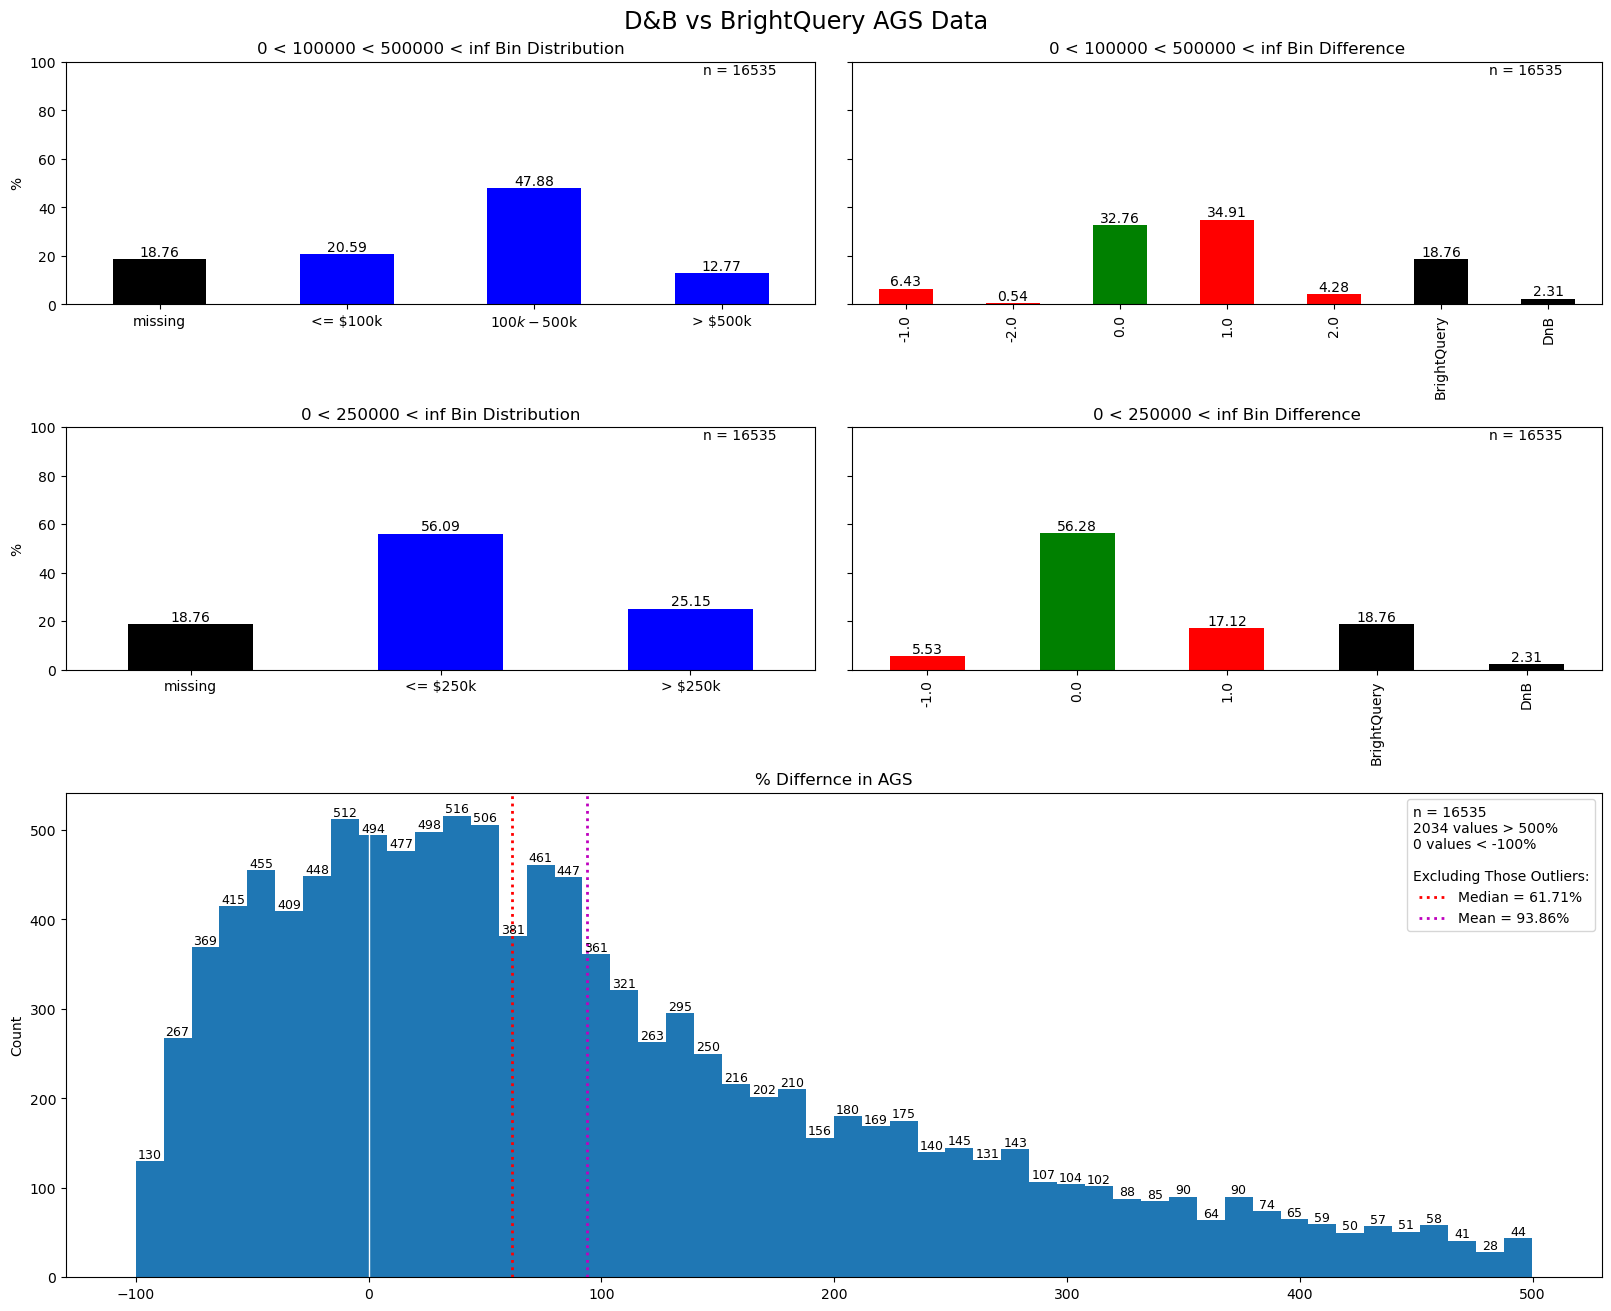

In [25]:
ags_charts(df, ags_cutoffs, cutoffs_250, 'vendor', 'dnb', comparate_base_dic)

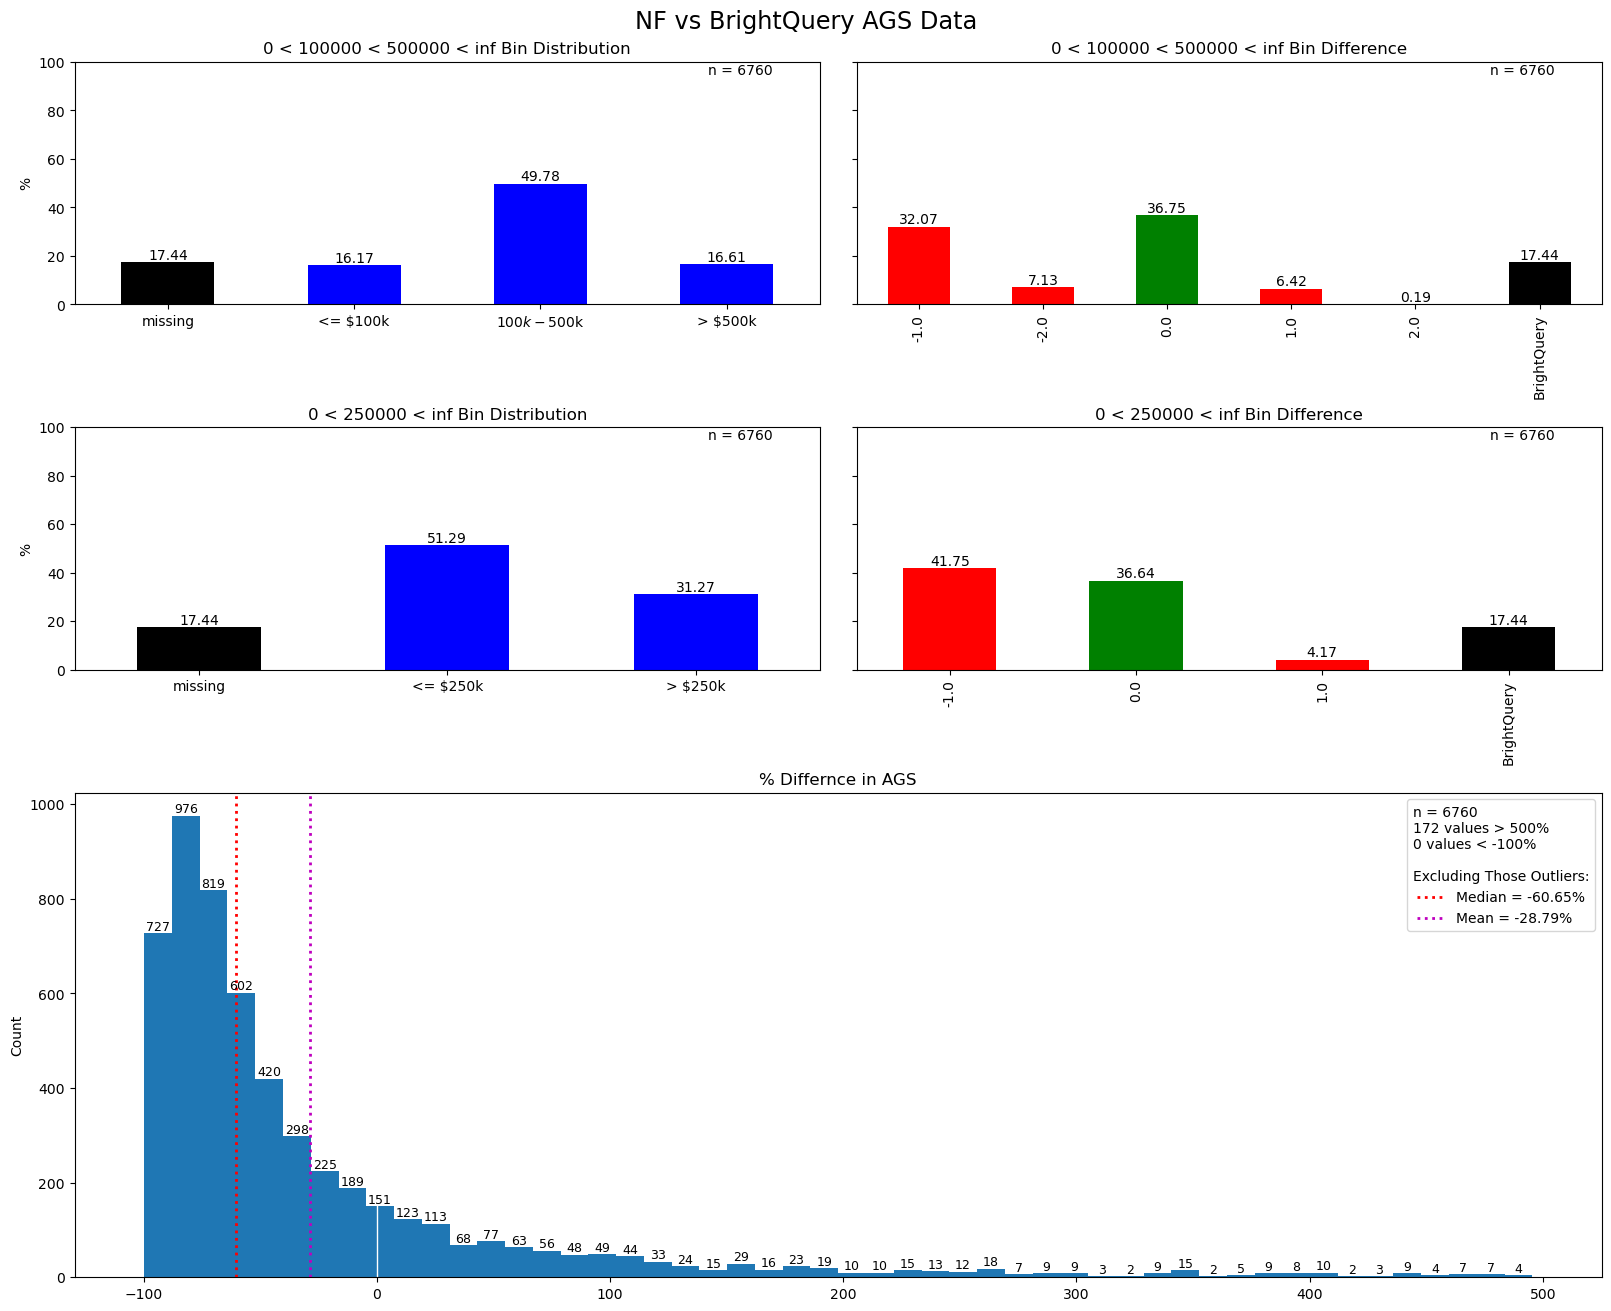

In [26]:
ags_charts(df, ags_cutoffs, cutoffs_250, 'vendor', 'nf', comparate_base_dic)

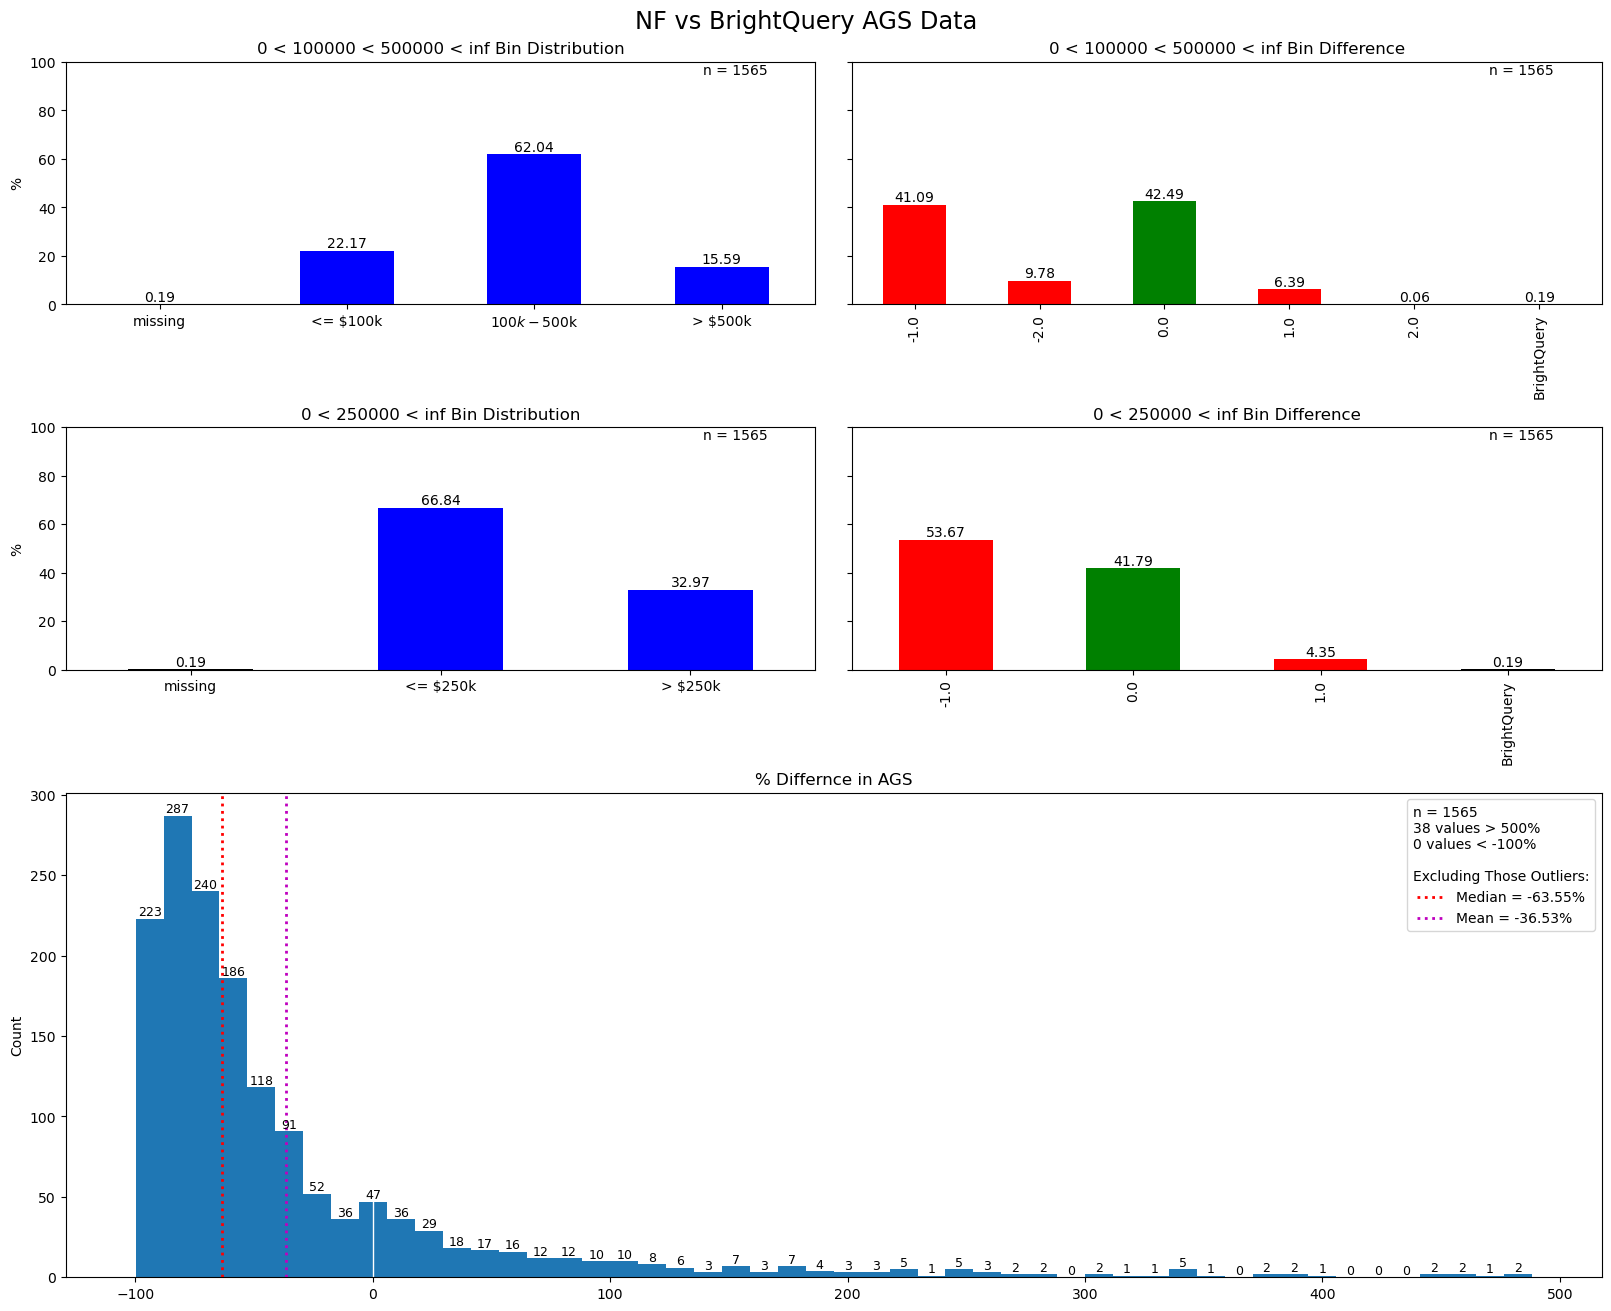

In [27]:
ags_charts(df, ags_cutoffs, cutoffs_250, 'vendor', 'nf', comparate_base_dic, 120)

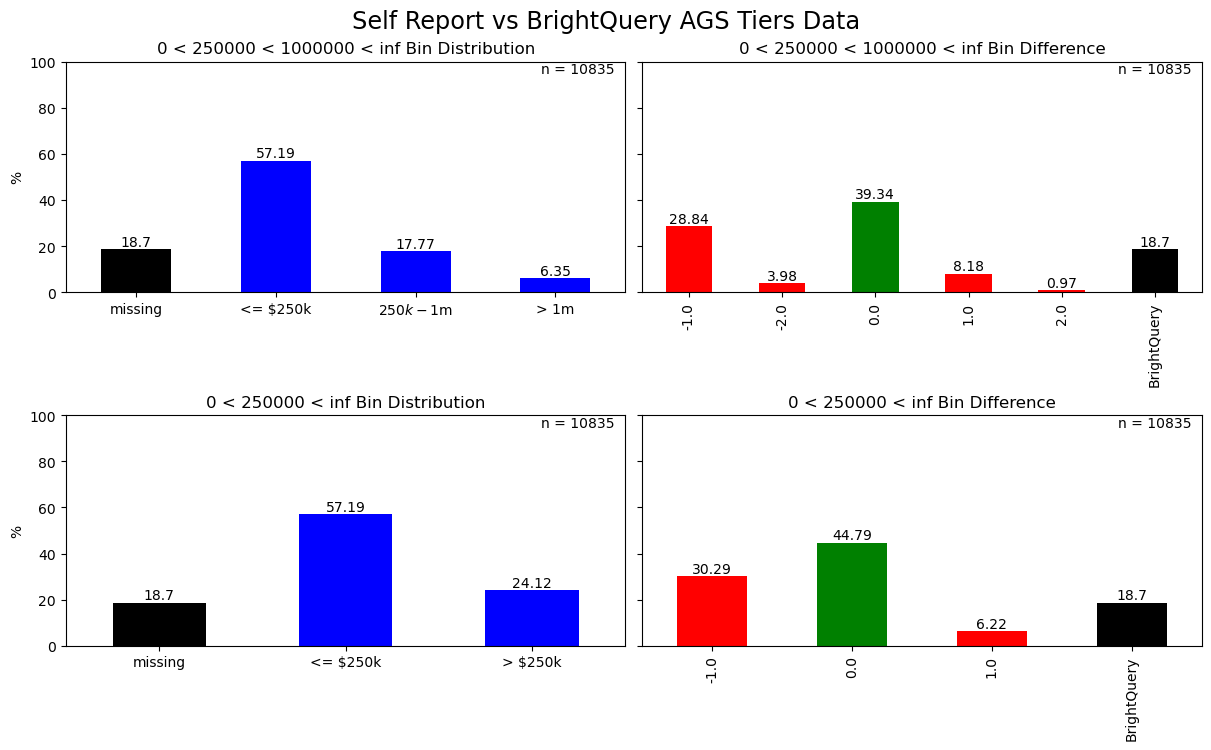

In [28]:
sr_ags_tier_charts(df, tier_cutoffs, cutoffs_250, 'vendor', comparate_base_dic)

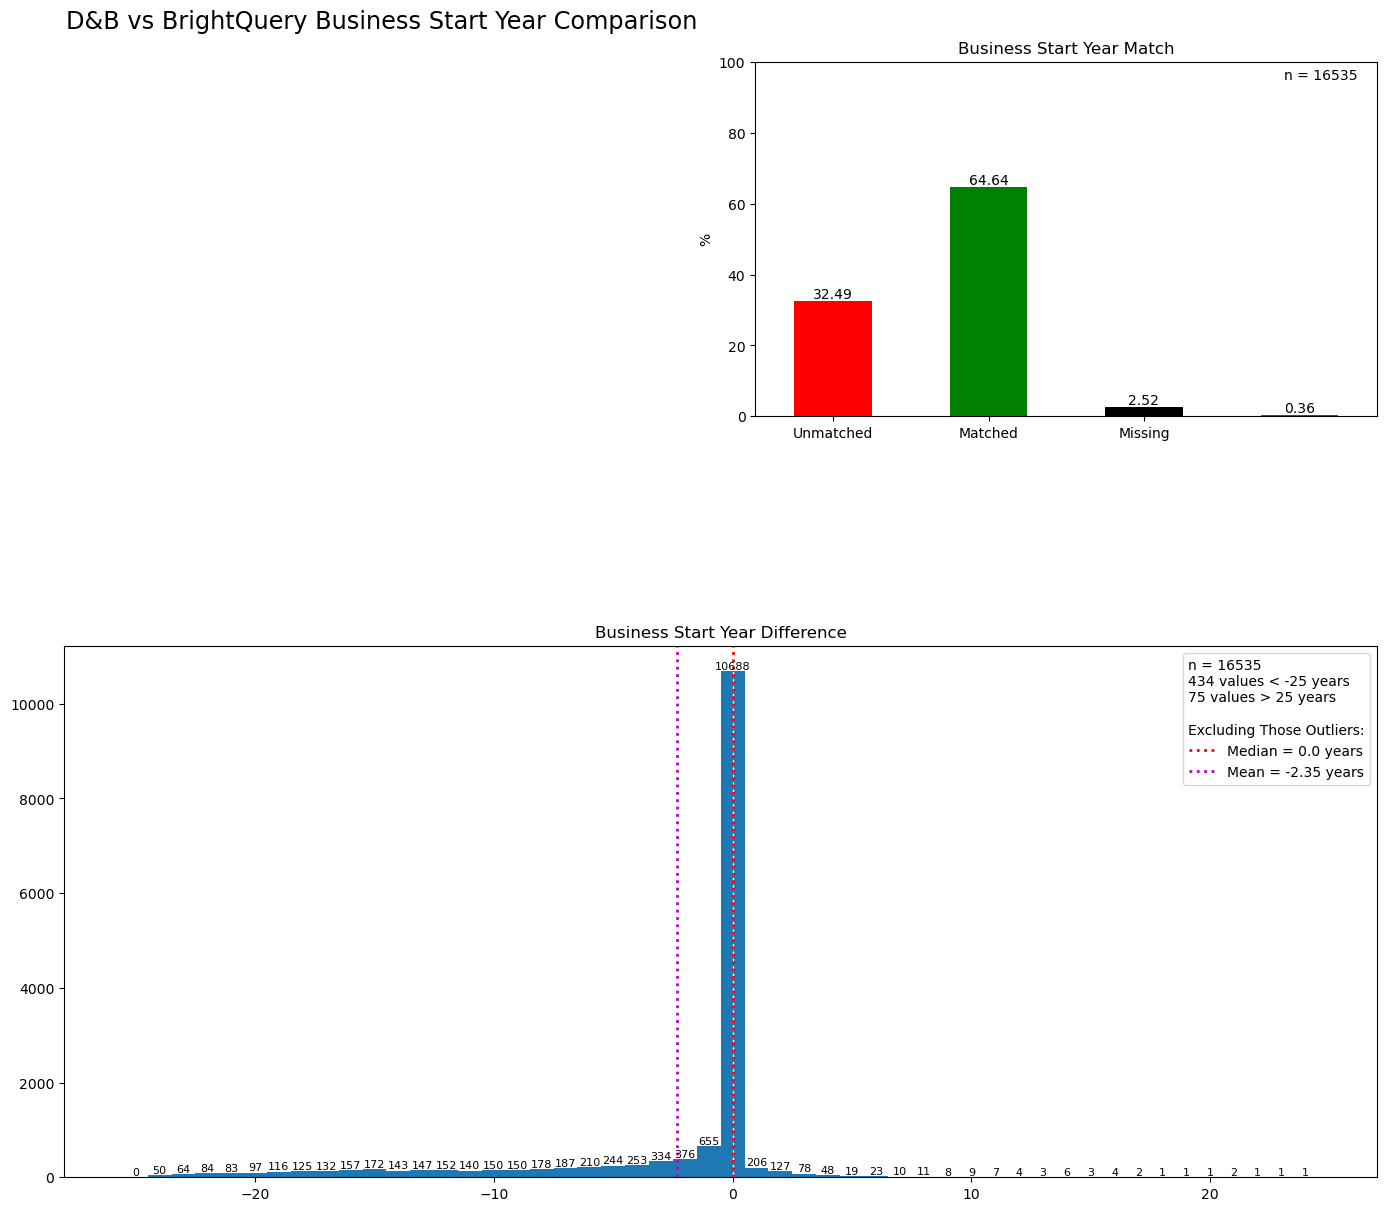

In [29]:
bsy_charts(df, 'vendor', 'dnb', comparate_base_dic)

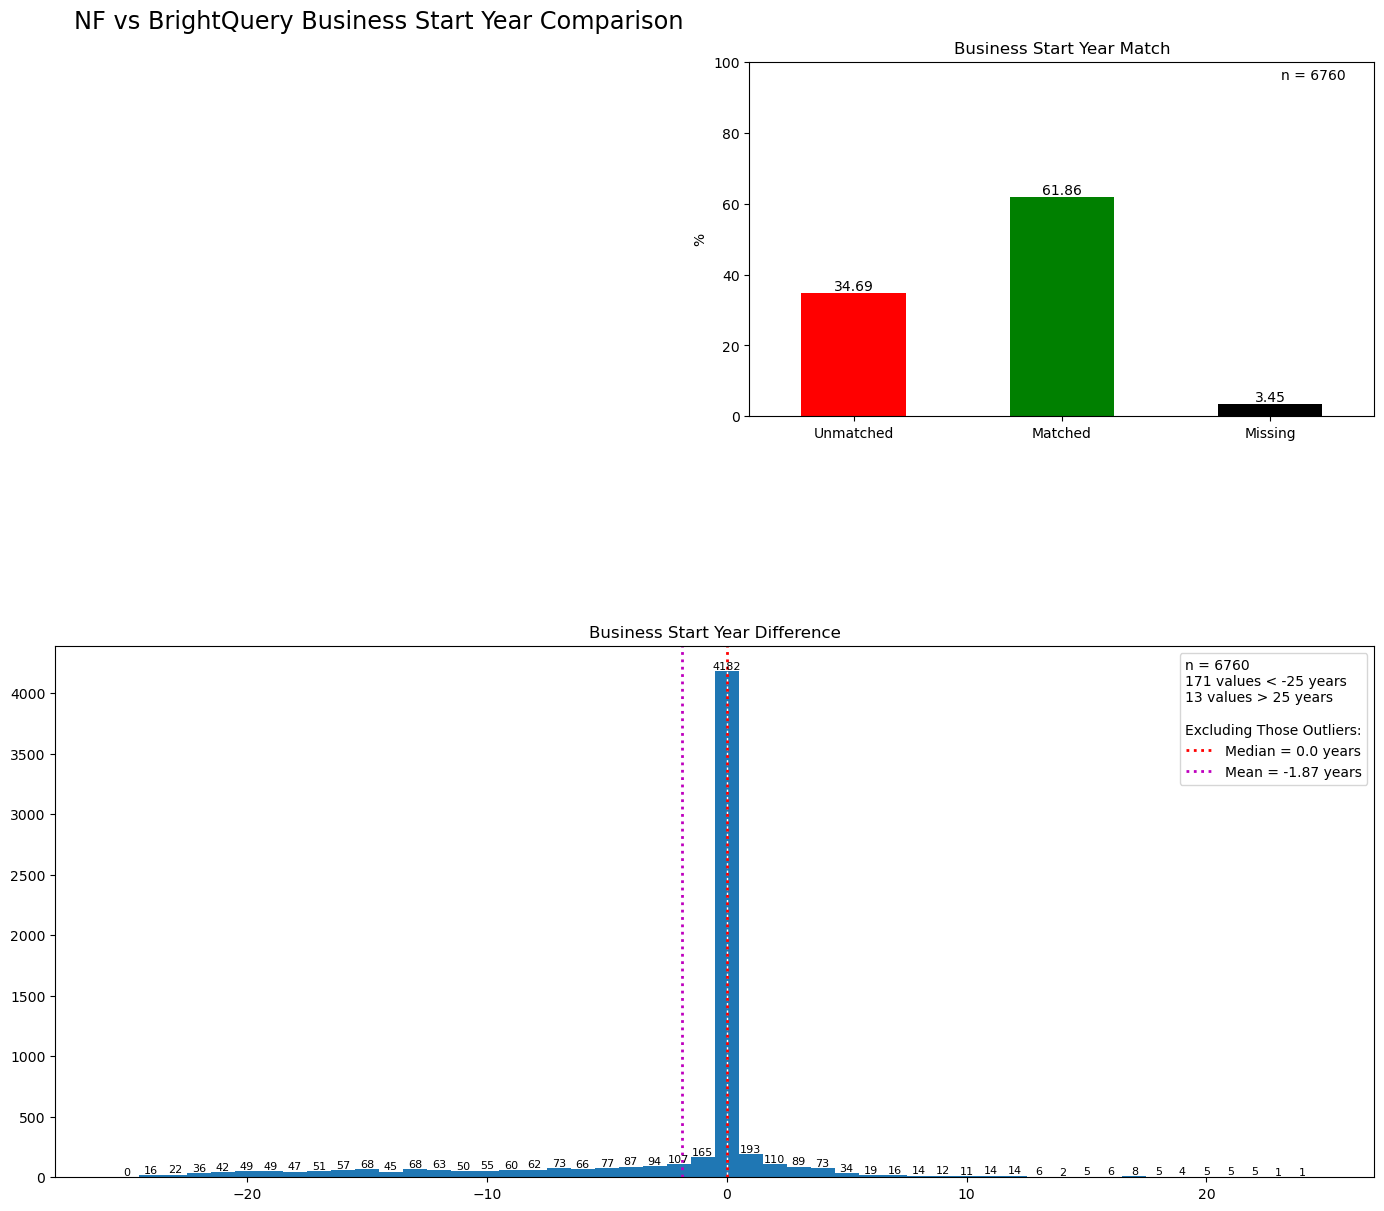

In [30]:
bsy_charts(df, 'vendor', 'nf', comparate_base_dic)

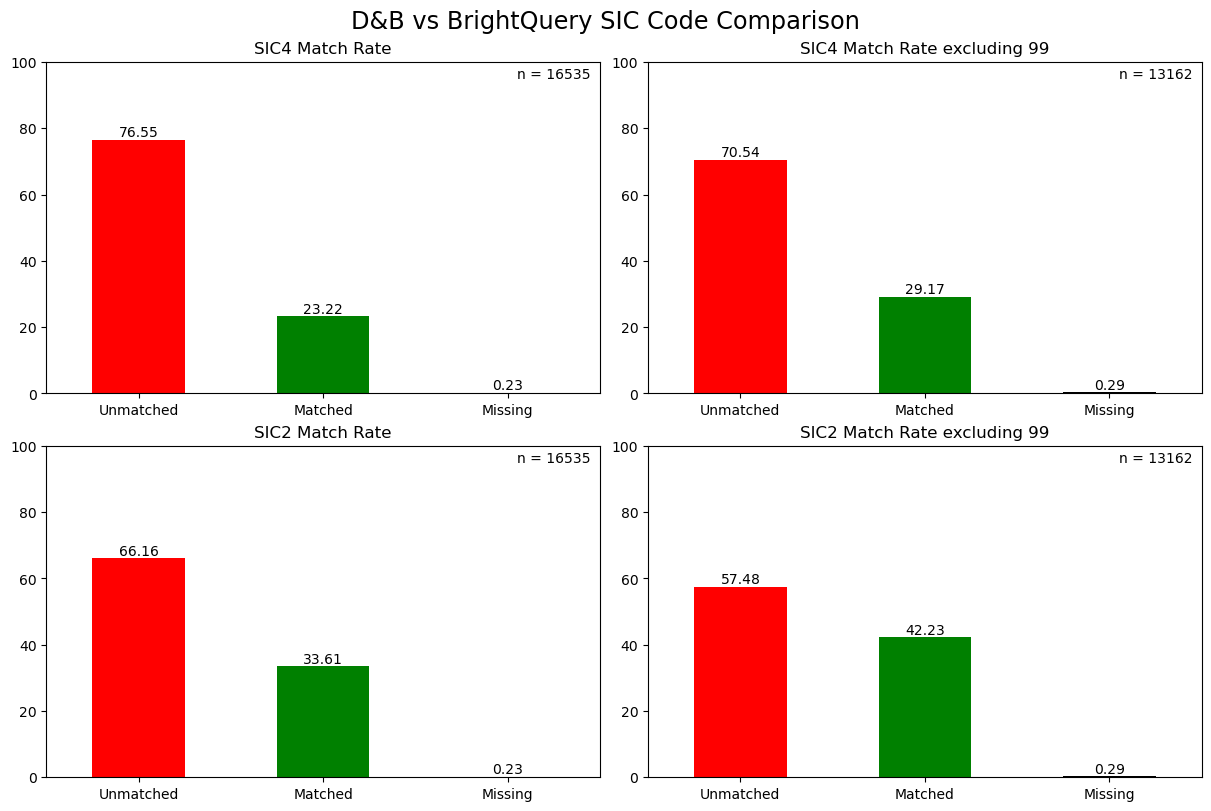

In [31]:
sic_charts(df, 'vendor', 'dnb', comparate_base_dic)

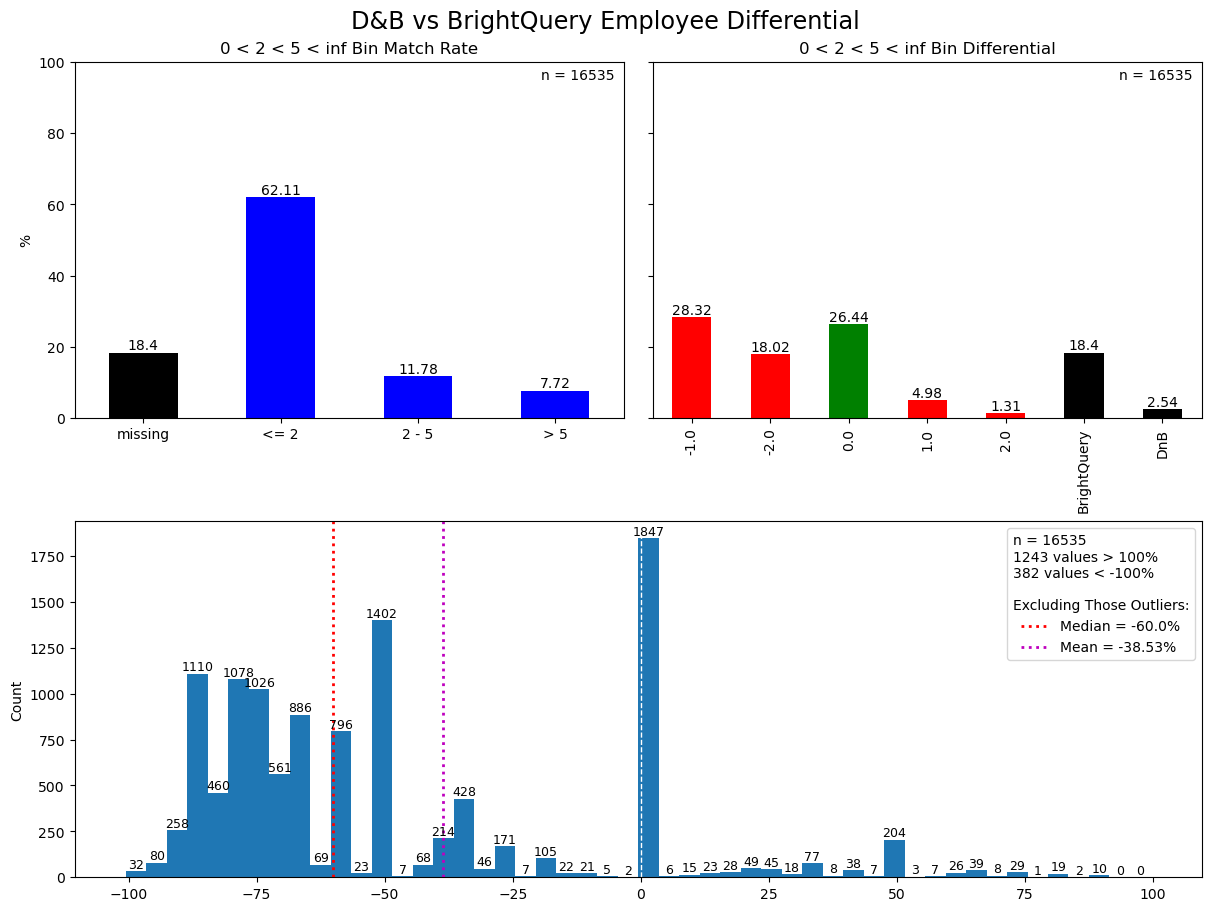

In [32]:
emp_charts(df, emp_cutoffs, 'vendor', 'dnb', comparate_base_dic)

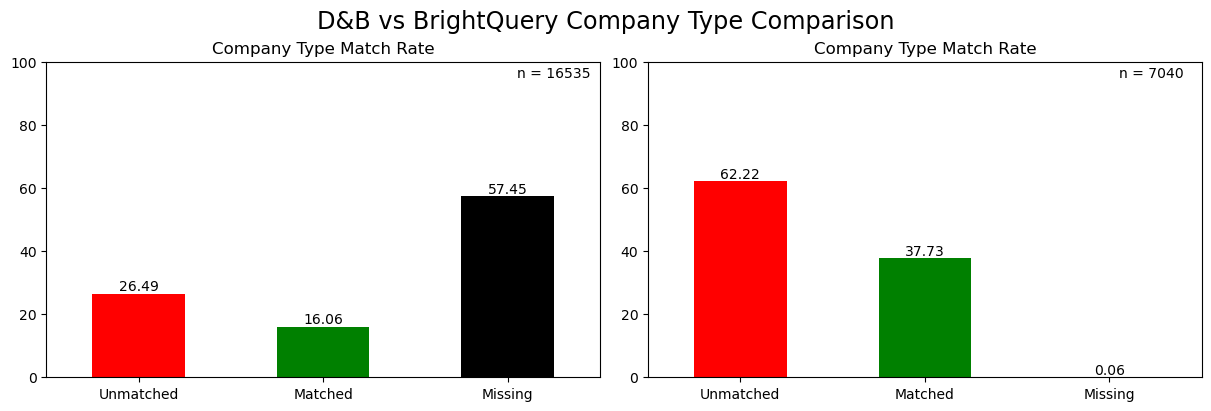

In [33]:
company_type_charts(df, 'vendor', 'dnb', comparate_base_dic)